# Signal Filtering With Neural Networks

<span style='font-size:18px'> <strong> Problem statement: </strong> <br> Assume that you have a known bandpass filter, now using this known filter generate 200 input-output pairs. Now, assume that somehow you forget all things about this filter but you still have 200 input-output pairs. 
</span>

<br>

<span style='font-size:18px'>
Now, built a DNN to approximate the lost band-pass filter. 
Please assume it is a causal symmetric filter.
</span>

<h3>Questions to answer</h3>

**Data preparation:**
* How do I produce meaningful data?
* What should the data look like?
* What filter to use?


**Neural Network Creation:**
* Which neural **network architecture** would be suitable?
* What should be the hidden neurons **activation function**?
* How many **hidden neurons and layers**?
* What should be the **error criteria**?
* How should I judge the **Accuracy** of my result?


# Index

1. [Index](#Index) <br>
2. [Importing Libraries](#Importing-Libraries) <br>
3. [Data Loading](#Data-Loading)<br>
4. [Preprocessing](#Preprocessing)<br>
5. [Evaluation Utilities](#Evaluation-utilities)<br>
6. [Linear Regression](#Simple-Linear-Regression) <br>
    6.1 [Model 1](#LR-Model-1)<br>
    6.2 [Model 2](#LR-Model-2)<br>
7. [FFNN](#FFNN) <br>
    7.1 [Model 1](#Model-1): 1 hidden layer simple <br>
    7.2 [Model 2](#Model-2): 2 hidden layers simple <br>
    7.3 [Model 3](#Model-3): 1 hidden layer, with dropout and L2 regularization <br>
    7.4 [Model 4](#Model-4): 2 hidden layers, with dropout and L2 regularization <br>
    7.5 [Model 5](#Model-5): 1 **Fat** hidden layer<br>
    7.6 [Model 6](#Model-6): 1 hidden layer with only regularization <br>
8. [RNN](#RNN) <br>
9. [Conclusion](#Conclusion) <br>
10. [References](#References) <br>
11. [Annexure 1](#Annex-1): Neural Networks for Noobs <br>
12. [Annexure 2](#Annex-2): Regularization <br>


# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json


%matplotlib inline

In [2]:
import tqdm

import torch
import torch.nn as nn
import torch.fft
print(torch.__version__)

1.7.0


# Data Loading

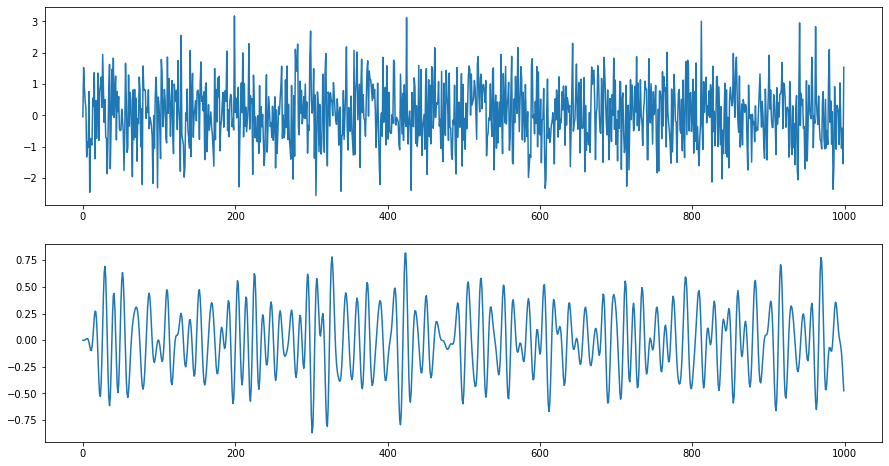

In [3]:
data_file = open('./data.json') 
data_dict = json.load(data_file)

plt.figure(figsize=(15,8))

plt.subplot(211)
plt.plot(data_dict[0]['x'])

plt.subplot(212)
plt.plot(data_dict[0]['y'])
plt.show()

In [4]:
train_dict = data_dict[:int(len(data_dict)*2/3)]
test_dict = data_dict[-int(len(data_dict)*1/3):]
print(f'Training data:{len(train_dict)}\nTesting data:{len(test_dict)}')

Training data:200
Testing data:100


In [5]:
#np.corrcoef(train_set[0]['x'],test_set[-1]['x'])

# Preprocessing

In [6]:
x_train = [train_dict[i]['x'] for i in range(len(train_dict))]
x_train = torch.Tensor(x_train)
x_train.shape

torch.Size([200, 1000])

In [7]:
y_train = [train_dict[i]['y'] for i in range(len(train_dict))]
y_train = torch.Tensor(y_train)
y_train.shape

torch.Size([200, 1000])

In [8]:
train = torch.utils.data.TensorDataset(x_train,y_train)

In [9]:
x_test = [test_dict[i]['x'] for i in range(len(test_dict))]
x_test = torch.Tensor(x_test)
x_test.shape

torch.Size([100, 1000])

In [10]:
y_test = [test_dict[i]['y'] for i in range(len(test_dict))]
y_test = torch.Tensor(y_test)
y_test.shape

torch.Size([100, 1000])

In [11]:
test = torch.utils.data.TensorDataset(x_test,y_test)

In [12]:
train_loader = torch.utils.data.DataLoader(train, batch_size = 1)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1)

In [13]:
x,y = next(iter(train_loader))
print(f'x: {x.shape}\ny: {y.shape}')

x: torch.Size([1, 1000])
y: torch.Size([1, 1000])


## Evaluation utilities

In [14]:
def evaluate(model, path):
    res = []
    
    model.eval()
    
    running_avg=0
    running_avg_fft=0
    i=0
    for x,y in train_loader:
        
        y_hat = model.forward(x)
        Y_hat = abs(np.fft.fft(y_hat.detach().numpy()))
        Y = abs(np.fft.fft(y.numpy()))
        
        
        corr = np.corrcoef(y.numpy(),y_hat.detach().numpy())[0,1]
        corr_fft = np.corrcoef(Y,Y_hat)[0,1]
        
        running_avg += (corr - running_avg)/(i+1)
        running_avg_fft += (corr_fft - running_avg_fft)/(i+1)
        i+=1
    
    print(f"Train Accuracy: {running_avg: .3f} || Train Accuracy (FFT): {running_avg_fft: .3f}")
    
    res.append([running_avg,running_avg_fft])
    
    running_avg=0
    running_avg_fft=0
    i=0
    for x,y in test_loader:
        
        y_hat = model.forward(x)
        Y_hat = abs(np.fft.fft(y_hat.detach().numpy()))
        Y = abs(np.fft.fft(y.numpy()))
        
        
        corr = np.corrcoef(y.numpy(),y_hat.detach().numpy())[0,1]
        corr_fft = np.corrcoef(Y,Y_hat)[0,1]
        
        running_avg += (corr - running_avg)/(i+1)
        running_avg_fft += (corr_fft - running_avg_fft)/(i+1)
        i+=1
    
    
    print(f"Test Accuracy: {running_avg: .3f} || Test Accuracy (FFT): {running_avg_fft: .3f}")
    
    res.append([running_avg,running_avg_fft])
    
    y_hat_test = model.forward(x_test[0])
    
    plt.figure(figsize=(15,8))
    
    plt.subplot(311)
    plt.plot(y_hat_test.detach().numpy() / y_hat_test.detach().numpy().max() , label='y_hat')
    plt.plot(y_test[0] / y_test[0].max(), label='y')
    plt.legend()
    
    plt.subplot(312)
    plt.plot(abs(np.fft.fft(y_hat_test.detach().numpy())))
    
    plt.subplot(313)
    plt.plot(abs(np.fft.fft(y_test[0])))
    
    plt.savefig('./eval/'+path)
    plt.show()
    
    return res

In [15]:
Model_results = []

# Simple Linear Regression

## LR Model 1

In [16]:
class LR1(nn.Module):
    def __init__(self):
        
        super(LR1,self).__init__()
        self.fc_o = nn.Linear(in_features=1000,out_features=1000)
        
    def forward(self,x):
        
        y = self.fc_o(x)
        
        return y

In [17]:
model = LR1()
criteria = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.1)

Running Loss:  0.00000: 100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


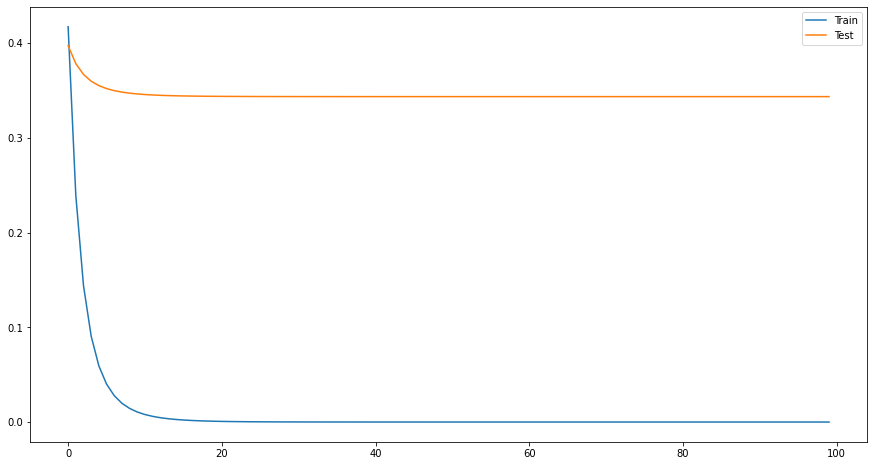

In [18]:
model.train()
epoch_nums = 100

running_loss_train = []
running_loss_test = []

epoch_t = tqdm.trange(epoch_nums,desc = 'Running Loss',leave = True)

for epoch in epoch_t:
    
    running_loss = 0
    i=0
    
    model.train()
    for x,y in train_loader:

        optim.zero_grad()

        y_hat = model.forward(x)

        loss = criteria(y_hat,y)
        loss.backward()
        
        optim.step()
        
        
        running_loss += (loss.item()-running_loss)/(i+1)
        i+=1
    
    epoch_t.set_description(f'Running Loss: {running_loss: .5f}')
    epoch_t.refresh()
    running_loss_train.append(running_loss)
    
    running_loss = 0
    i=0
    model.eval()
    for x,y in test_loader:
        
        y_hat = model.forward(x)
        
        loss = criteria(y_hat, y)
        
        running_loss += (loss.item()-running_loss)/(i+1)
        i+=1
    
    running_loss_test.append(running_loss)
    
plt.figure(figsize=(15,8))
plt.plot(running_loss_train, label='Train')
plt.plot(running_loss_test, label='Test')
plt.savefig('./loss/lr_1.png')
plt.legend()
plt.show()

<img src='./loss/lr_1.png'>

In [19]:
#torch.save(model.state_dict(),'./models/lr_1.pth')

In [21]:
#model.load_state_dict(torch.load('./models/lr_1.pth'))

<All keys matched successfully>

Train Accuracy:  1.000 || Train Accuracy (FFT):  1.000
Test Accuracy:  0.114 || Test Accuracy (FFT):  0.152


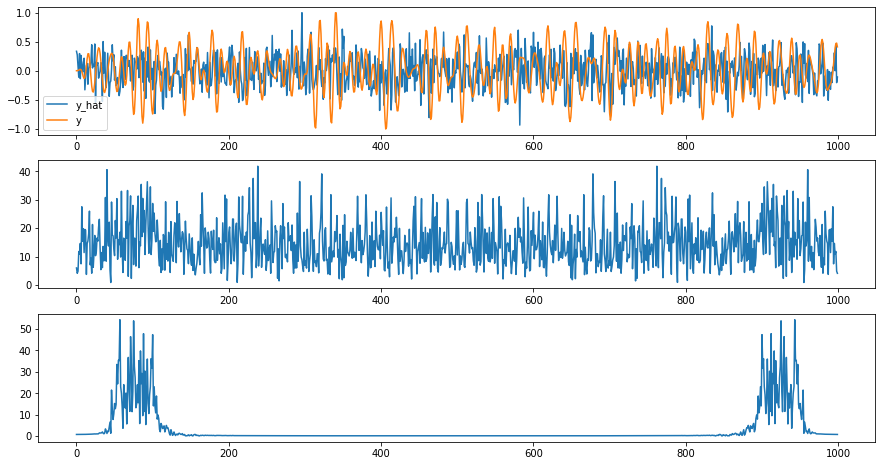

In [19]:
Model_results.append(evaluate(model,'lr_1.png'))

## LR Model 2

In [20]:
class LR2(nn.Module):
    def __init__(self):
        
        super(LR2,self).__init__()
        self.fc_o = nn.Linear(in_features=1000,out_features=1000)
        
    def forward(self,x):
        
        y = self.fc_o(x)
        
        return y

In [21]:
model = LR2()
criteria = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.005)

In [22]:
# model.train()
# epoch_nums = 100

# running_loss_train = []
# running_loss_test = []

# epoch_t = tqdm.trange(epoch_nums,desc = 'Running Loss',leave = True)

# for epoch in epoch_t:
    
#     running_loss = 0
#     i=0
    
#     model.train()
#     for x,y in train_loader:

#         optim.zero_grad()

#         y_hat = model.forward(x)

#         loss = criteria(y_hat,y)
#         loss.backward()
        
#         optim.step()
        
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     epoch_t.set_description(f'Running Loss: {running_loss: .5f}')
#     epoch_t.refresh()
#     running_loss_train.append(running_loss)
    
#     running_loss = 0
#     i=0
#     model.eval()
#     for x,y in test_loader:
        
#         y_hat = model.forward(x)
        
#         loss = criteria(y_hat, y)
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     running_loss_test.append(running_loss)
    
# plt.figure(figsize=(15,8))
# plt.plot(running_loss_train, label='Train')
# plt.plot(running_loss_test, label='Test')
# plt.savefig('./loss/lr_2.png')
# plt.legend()
# plt.show()

<img src='./loss/lr_2.png'>

In [81]:
#torch.save(model.state_dict(),'./models/lr_2.pth')

In [23]:
model.load_state_dict(torch.load('./models/lr_2.pth'))

<All keys matched successfully>

Train Accuracy:  0.996 || Train Accuracy (FFT):  0.998
Test Accuracy:  0.440 || Test Accuracy (FFT):  0.802


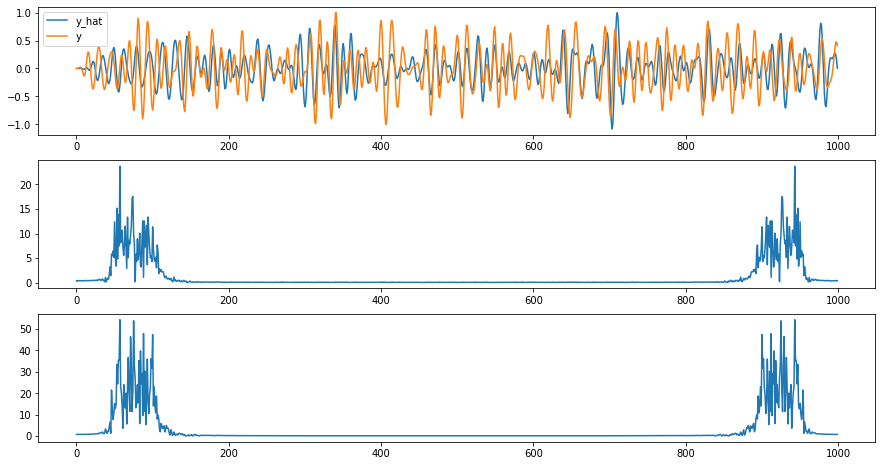

In [24]:
Model_results.append(evaluate(model,'lr_2.png'))

# FFNN

## Model 1

Simplest possible model. Let's see how this works against this data. Technically should not be be able to learn complex funcions.

<img src='./annex/nn.svg'>

In [25]:
class ffnn_1(nn.Module):
    
    def __init__ (self):
        super(ffnn_1, self).__init__()
        
        self.fc1 = nn.Linear(1000, 1000)
        self.relu1 = nn.ReLU()
        self.fc_o = nn.Linear(1000, 1000)
    
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu1(x)
        y = self.fc_o(x)
        return y

In [26]:
model = ffnn_1()
criteria = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=1, momentum=0.1)

In [30]:
model.train()
epoch_nums = 100

running_loss_train = []
running_loss_test = []

epoch_t = tqdm.trange(epoch_nums,desc = 'Running Loss',leave = True)

for epoch in epoch_t:
    
    running_loss = 0
    i=0
    
    model.train()
    for x,y in train_loader:

        optim.zero_grad()

        y_hat = model.forward(x)

        loss = criteria(y_hat,y)
        loss.backward()
        
        optim.step()
        
        
        running_loss += (loss.item()-running_loss)/(i+1)
        i+=1
    
    epoch_t.set_description(f'Running Loss: {running_loss: .5f}')
    epoch_t.refresh()
    running_loss_train.append(running_loss)
    
    running_loss = 0
    i=0
    model.eval()
    for x,y in test_loader:
        
        y_hat = model.forward(x)
        
        loss = criteria(y_hat, y)
        
        running_loss += (loss.item()-running_loss)/(i+1)
        i+=1
    
    running_loss_test.append(running_loss)
    
plt.figure(figsize=(15,8))
plt.plot(running_loss_train, label='Train')
plt.plot(running_loss_test, label='Test')
plt.savefig('./loss/ffnn_1.png')
plt.legend()
plt.show()

Running Loss:  0.00000:  20%|██        | 20/100 [01:28<05:55,  4.45s/it]


KeyboardInterrupt: 

<img src='./loss/ffnn_1.png'>

In [20]:
#torch.save(model.state_dict(),'./models/ffnn_1.pth')

In [28]:
model.load_state_dict(torch.load('./models/ffnn_1.pth'))

<All keys matched successfully>

Train Accuracy:  1.000 || Train Accuracy (FFT):  1.000
Test Accuracy:  0.211 || Test Accuracy (FFT):  0.543


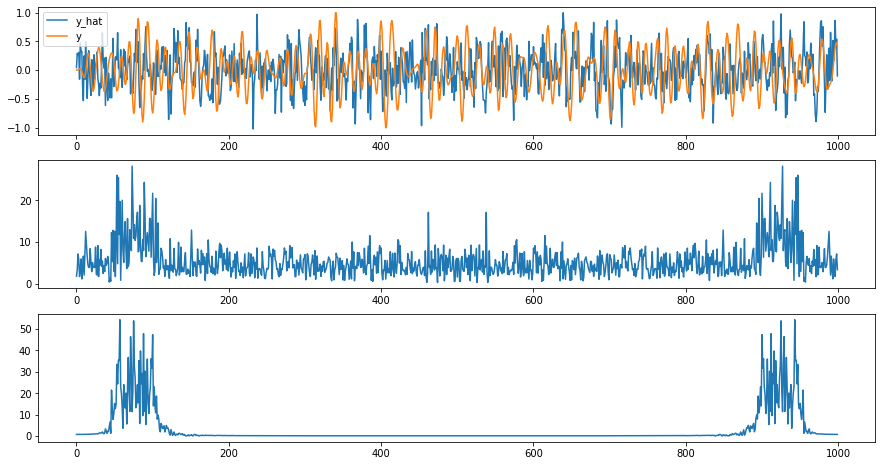

In [29]:
Model_results.append(evaluate(model,'ffnn_1.png'))

## Model 2

More power than the first one. Let's see how this does.
<img src='./annex/nn2.svg'>

In [31]:
class ffnn_2(nn.Module):
    
    def __init__ (self):
        super(ffnn_2, self).__init__()
        
        self.fc1 = nn.Linear(1000, 1000)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1000, 1000)
        self.relu2 = nn.ReLU()
        self.fc_o = nn.Linear(1000, 1000)
    
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        y = self.fc_o(x)
        return y

In [32]:
model = ffnn_2()
criteria = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=1, momentum=0.1)

In [33]:
# model.train()
# epoch_nums = 100

# running_loss_train = []
# running_loss_test = []

# epoch_t = tqdm.trange(epoch_nums,desc = 'Running Loss',leave = True)

# for epoch in epoch_t:
    
#     running_loss = 0
#     i=0
    
#     model.train()
#     for x,y in train_loader:

#         optim.zero_grad()

#         y_hat = model.forward(x)

#         loss = criteria(y_hat,y)
#         loss.backward()
        
#         optim.step()
        
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     epoch_t.set_description(f'Running Loss: {running_loss: .5f}')
#     epoch_t.refresh()
#     running_loss_train.append(running_loss)
    
#     running_loss = 0
#     i=0
#     model.eval()
#     for x,y in test_loader:
        
#         y_hat = model.forward(x)
        
#         loss = criteria(y_hat, y)
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     running_loss_test.append(running_loss)
    
# plt.figure(figsize=(15,8))
# plt.plot(running_loss_train, label='Train')
# plt.plot(running_loss_test, label='Test')
# plt.savefig('./loss/ffnn_2.png')
# plt.legend()
# plt.show()

<img src='./loss/ffnn_2.png'>

In [178]:
#torch.save(model.state_dict(),'./models/ffnn_2.pth')

In [34]:
model.load_state_dict(torch.load('./models/ffnn_2.pth'))

<All keys matched successfully>

Train Accuracy:  0.999 || Train Accuracy (FFT):  1.000
Test Accuracy:  0.251 || Test Accuracy (FFT):  0.697


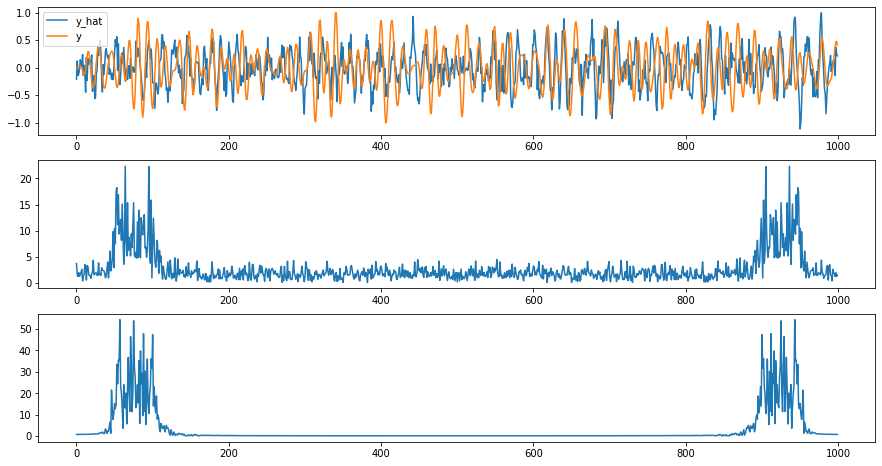

In [35]:
Model_results.append(evaluate(model,'ffnn_2.png'))

## Model 3

Using the first model, but this time with dropout and reguraliation
<img src='./annex/nn.svg'>

In [36]:
class ffnn_3(nn.Module):
    
    def __init__ (self):
        super(ffnn_3, self).__init__()
        
        self.fc1 = nn.Linear(1000, 2000)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc_o = nn.Linear(2000, 1000)
    
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        y = self.fc_o(x)
        return y

In [37]:
model = ffnn_3()
criteria = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=1, momentum=0.1, weight_decay=0.001)

Running Loss:  0.01754: 100%|██████████| 100/100 [10:56<00:00,  6.56s/it]


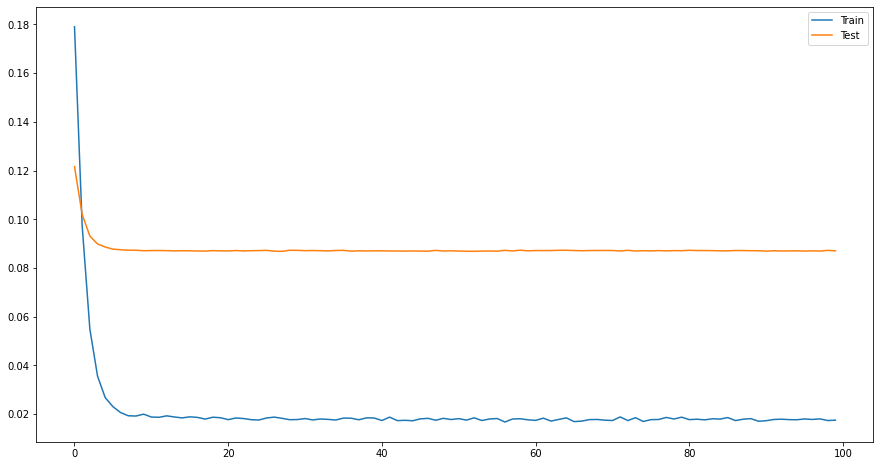

In [188]:
# model.train()
# epoch_nums = 100

# running_loss_train = []
# running_loss_test = []

# epoch_t = tqdm.trange(epoch_nums,desc = 'Running Loss',leave = True)

# for epoch in epoch_t:
    
#     running_loss = 0
#     i=0
    
#     model.train()
#     for x,y in train_loader:

#         optim.zero_grad()

#         y_hat = model.forward(x)

#         loss = criteria(y_hat,y)
#         loss.backward()
        
#         optim.step()
        
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     epoch_t.set_description(f'Running Loss: {running_loss: .5f}')
#     epoch_t.refresh()
#     running_loss_train.append(running_loss)
    
#     running_loss = 0
#     i=0
#     model.eval()
#     for x,y in test_loader:
        
#         y_hat = model.forward(x)
        
#         loss = criteria(y_hat, y)
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     running_loss_test.append(running_loss)
    
# plt.figure(figsize=(15,8))
# plt.plot(running_loss_train, label='Train')
# plt.plot(running_loss_test, label='Test')
# plt.savefig('./loss/ffnn_3.png')
# plt.legend()
# plt.show()

<!-- <img src='./loss/ffnn_3.png'> -->

In [190]:
#torch.save(model.state_dict(),'./models/ffnn_3.pth')

In [38]:
model.load_state_dict(torch.load('./models/ffnn_3.pth'))

<All keys matched successfully>

Train Accuracy:  0.969 || Train Accuracy (FFT):  0.983
Test Accuracy:  0.391 || Test Accuracy (FFT):  0.796


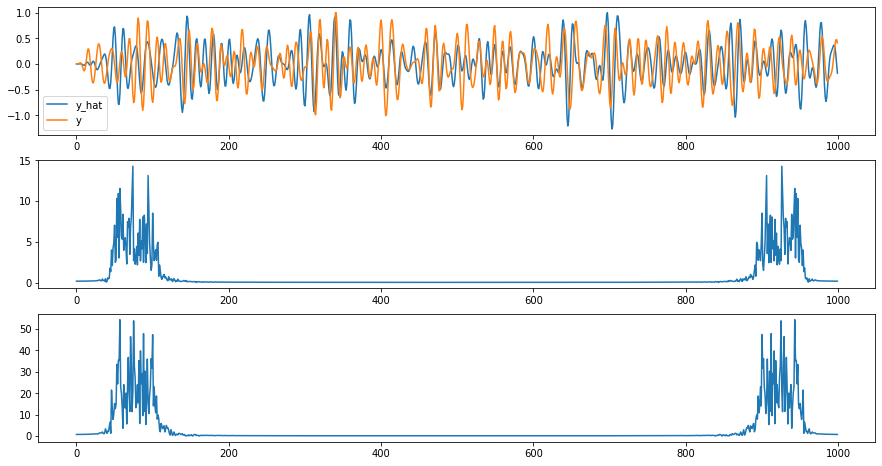

In [39]:
Model_results.append(evaluate(model,'ffnn_3.png'))

## Model 4

Using the Second model, but this time with dropout and reguraliation
<img src='./annex/nn2.svg'>

In [40]:
class ffnn_4(nn.Module):
    
    def __init__ (self):
        super(ffnn_4, self).__init__()
        
        self.fc1 = nn.Linear(1000, 2000)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.4)
        
        self.fc2 = nn.Linear(2000, 2000)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.4)
        
        self.fc_o = nn.Linear(2000, 1000)
    
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        y = self.fc_o(x)
        return y

In [41]:
model = ffnn_4()
criteria = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=1, momentum=0.1, weight_decay=0.0001)

Running Loss:  0.01284: 100%|██████████| 100/100 [21:11<00:00, 12.71s/it]


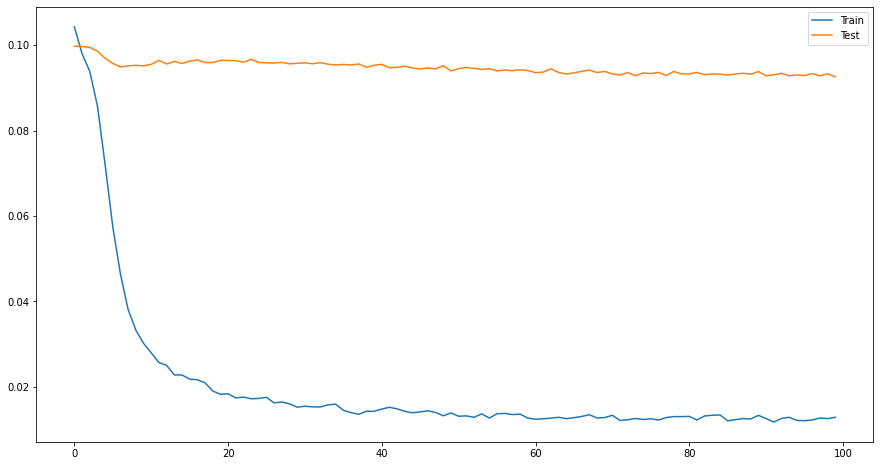

In [63]:
# model.train()
# epoch_nums = 100

# running_loss_train = []
# running_loss_test = []

# epoch_t = tqdm.trange(epoch_nums,desc = 'Running Loss',leave = True)

# for epoch in epoch_t:
    
#     running_loss = 0
#     i=0
    
#     model.train()
#     for x,y in train_loader:

#         optim.zero_grad()

#         y_hat = model.forward(x)

#         loss = criteria(y_hat,y)
#         loss.backward()
        
#         optim.step()
        
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     epoch_t.set_description(f'Running Loss: {running_loss: .5f}')
#     epoch_t.refresh()
#     running_loss_train.append(running_loss)
    
#     running_loss = 0
#     i=0
#     model.eval()
#     for x,y in test_loader:
        
#         y_hat = model.forward(x)
        
#         loss = criteria(y_hat, y)
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     running_loss_test.append(running_loss)
    
# plt.figure(figsize=(15,8))
# plt.plot(running_loss_train, label='Train')
# plt.plot(running_loss_test, label='Test')
# plt.savefig('./loss/ffnn_4.png')
# plt.legend()
# plt.show()

In [67]:
#torch.save(model.state_dict(),'./models/ffnn_4.pth')

In [42]:
model.load_state_dict(torch.load('./ffnn_4.pth'))

<All keys matched successfully>

Train Accuracy:  0.986 || Train Accuracy (FFT):  0.992
Test Accuracy:  0.337 || Test Accuracy (FFT):  0.789


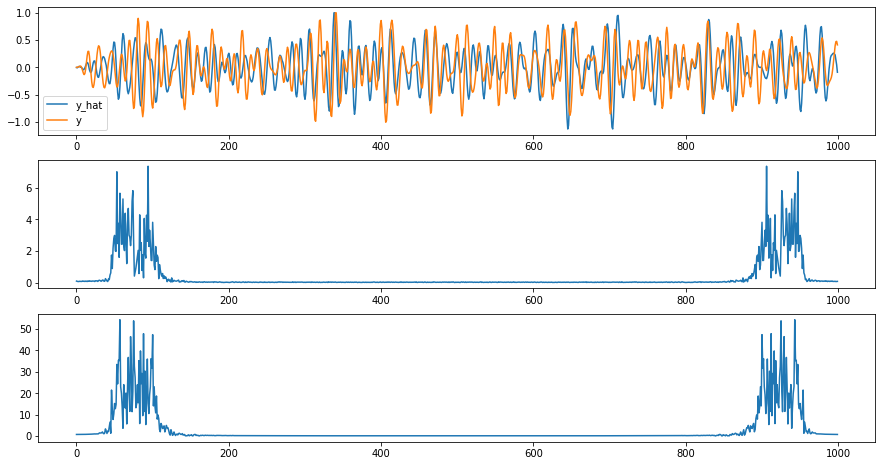

In [43]:
Model_results.append(evaluate(model,'ffnn_4.png'))

## Model 5

Using the first model, but with larger hidden layer
<img src='./annex/nn_fat.svg'>

In [44]:
class ffnn_5(nn.Module):
    
    def __init__ (self):
        super(ffnn_5, self).__init__()
        
        self.fc1 = nn.Linear(1000, 500)
        self.relu1 = nn.ReLU()
        self.fc_o = nn.Linear(500, 1000)
    
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu1(x)
        y = self.fc_o(x)
        return y

In [45]:
model = ffnn_5()
criteria = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=1, momentum=0.1, weight_decay=0.0001)

Running Loss:  0.00011: 100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


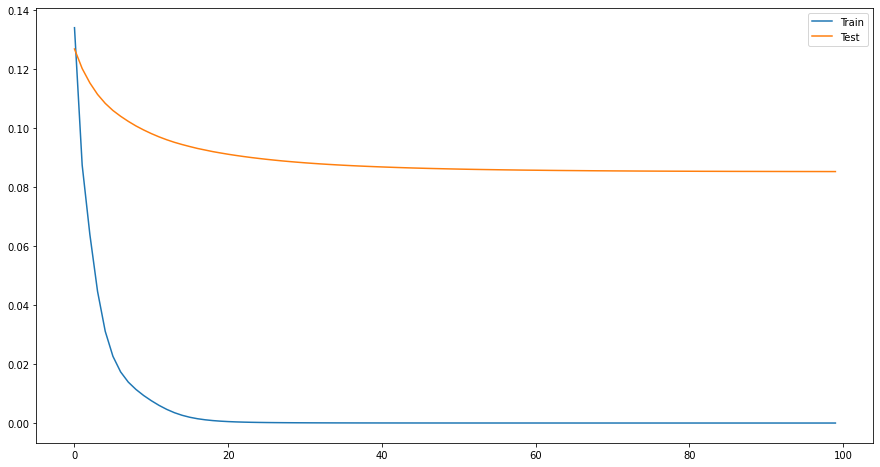

In [32]:
# model.train()
# epoch_nums = 100

# running_loss_train = []
# running_loss_test = []

# epoch_t = tqdm.trange(epoch_nums,desc = 'Running Loss',leave = True)

# for epoch in epoch_t:
    
#     running_loss = 0
#     i=0
    
#     model.train()
#     for x,y in train_loader:

#         optim.zero_grad()

#         y_hat = model.forward(x)

#         loss = criteria(y_hat,y)
#         loss.backward()
        
#         optim.step()
        
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     epoch_t.set_description(f'Running Loss: {running_loss: .5f}')
#     epoch_t.refresh()
#     running_loss_train.append(running_loss)
    
#     running_loss = 0
#     i=0
#     model.eval()
#     for x,y in test_loader:
        
#         y_hat = model.forward(x)
        
#         loss = criteria(y_hat, y)
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     running_loss_test.append(running_loss)
    
# plt.figure(figsize=(15,8))
# plt.plot(running_loss_train, label='Train')
# plt.plot(running_loss_test, label='Test')
# plt.savefig('./loss/ffnn_5.png')
# plt.legend()
# plt.show()

In [37]:
#torch.save(model.state_dict(),'./models/ffnn_5.pth')

In [47]:
model.load_state_dict(torch.load('./models/ffnn_5.pth'))

<All keys matched successfully>

Train Accuracy:  1.000 || Train Accuracy (FFT):  1.000
Test Accuracy:  0.402 || Test Accuracy (FFT):  0.794


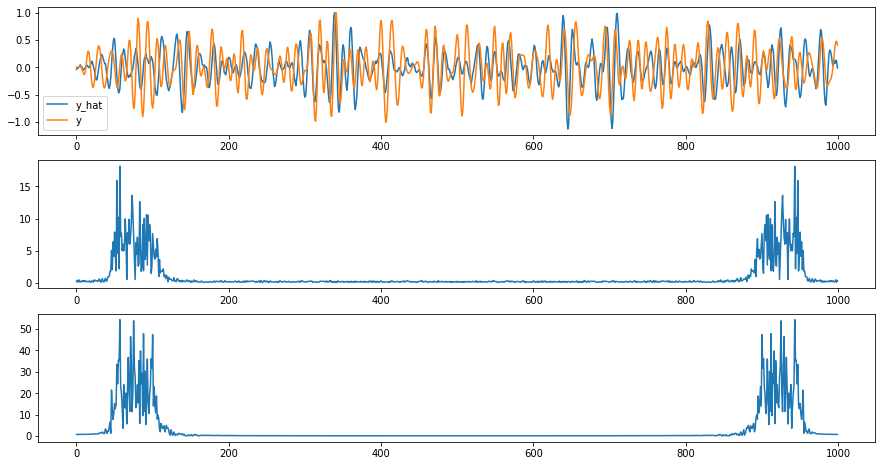

In [48]:
Model_results.append(evaluate(model,'ffnn_5.png'))

## Model 6

Simplest possible model. Let's see how this works against this data. Technically should not be be able to learn complex funcions.

<img src='./annex/nn.svg'>

In [49]:
class ffnn_6(nn.Module):
    
    def __init__ (self):
        super(ffnn_6, self).__init__()
        
        self.fc1 = nn.Linear(1000, 1000)
        self.relu1 = nn.ReLU()
        self.fc_o = nn.Linear(1000, 1000)
    
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu1(x)
        y = self.fc_o(x)
        return y

In [50]:
model = ffnn_6()
criteria = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=1, momentum=0.1, weight_decay=0.0003)

In [53]:
# model.train()
# epoch_nums = 100

# running_loss_train = []
# running_loss_test = []

# epoch_t = tqdm.trange(epoch_nums,desc = 'Running Loss',leave = True)

# for epoch in epoch_t:
    
#     running_loss = 0
#     i=0
    
#     model.train()
#     for x,y in train_loader:

#         optim.zero_grad()

#         y_hat = model.forward(x)

#         loss = criteria(y_hat,y)
#         loss.backward()
        
#         optim.step()
        
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     epoch_t.set_description(f'Running Loss: {running_loss: .5f}')
#     epoch_t.refresh()
#     running_loss_train.append(running_loss)
    
#     running_loss = 0
#     i=0
#     model.eval()
#     for x,y in test_loader:
        
#         y_hat = model.forward(x)
        
#         loss = criteria(y_hat, y)
        
#         running_loss += (loss.item()-running_loss)/(i+1)
#         i+=1
    
#     running_loss_test.append(running_loss)
    
# plt.figure(figsize=(15,8))
# plt.plot(running_loss_train, label='Train')
# plt.plot(running_loss_test, label='Test')
# plt.savefig('./loss/ffnn_6.png')
# plt.legend()
# plt.show()

<img src='./loss/ffnn_6.png'>

In [46]:
#torch.save(model.state_dict(),'./models/ffnn_6.pth')

In [51]:
model.load_state_dict(torch.load('./models/ffnn_6.pth'))

<All keys matched successfully>

Train Accuracy:  0.998 || Train Accuracy (FFT):  0.999
Test Accuracy:  0.415 || Test Accuracy (FFT):  0.797


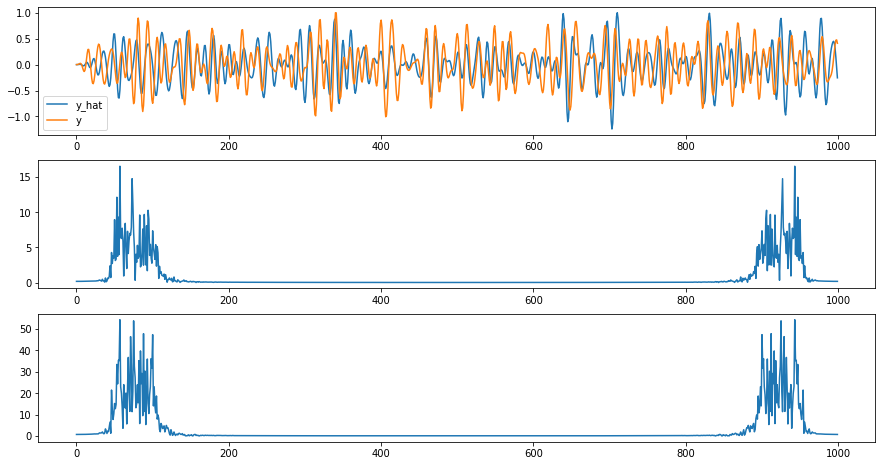

In [52]:
Model_results.append(evaluate(model,'ffnn_6.png'))

<!-- In this simple MLP model, I used: 

* Square architechture, 5 x 1000 hidden layers
* SGD optimizer -->

## Model 7

<img src='./meme/go_deeper.jpeg'>

In [53]:
class ffnn_7(nn.Module):
    
    def __init__ (self):
        super(ffnn_7, self).__init__()
        
        self.fc1 = nn.Linear(1000, 1000)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0)
        
        self.fc2 = nn.Linear(1000, 1000)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0)
        
        self.fc3 = nn.Linear(1000, 1000)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0)
        
        self.fc4 = nn.Linear(1000, 1000)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(p=0)
        
        self.fc5 = nn.Linear(1000, 1000)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(p=0)
        
        self.fc_o = nn.Linear(1000, 1000)
    
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.dropout5(x)
        
        y = self.fc_o(x)
        
        return y

In [54]:
model = ffnn_7()
criteria = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=1, momentum=0.1, weight_decay=0.0001)

In [55]:
model.train()
epoch_nums = 100

running_loss_train = []
running_loss_test = []

epoch_t = tqdm.trange(epoch_nums,desc = 'Running Loss',leave = True)

for epoch in epoch_t:
    
    running_loss = 0
    i=0
    
    model.train()
    for x,y in train_loader:

        optim.zero_grad()

        y_hat = model.forward(x)

        loss = criteria(y_hat,y)
        loss.backward()
        
        optim.step()
        
        
        running_loss += (loss.item()-running_loss)/(i+1)
        i+=1
    
    epoch_t.set_description(f'Running Loss: {running_loss: .5f}')
    epoch_t.refresh()
    running_loss_train.append(running_loss)
    
    running_loss = 0
    i=0
    model.eval()
    for x,y in test_loader:
        
        y_hat = model.forward(x)
        
        loss = criteria(y_hat, y)
        
        running_loss += (loss.item()-running_loss)/(i+1)
        i+=1
    
    running_loss_test.append(running_loss)
    
plt.figure(figsize=(15,8))
plt.plot(running_loss_train, label='Train')
plt.plot(running_loss_test, label='Test')
plt.savefig('./loss/ffnn_7.png')
plt.legend()
plt.show()

Running Loss:  0.09944:   1%|          | 1/100 [00:23<39:22, 23.86s/it]


KeyboardInterrupt: 

<img src='./loss/ffnn_7.png'>

In [25]:
#torch.save(model.state_dict(),'./models/ffnn_7.pth')

In [56]:
model.load_state_dict(torch.load('./models/ffnn_7.pth'))

<All keys matched successfully>

Train Accuracy:  0.976 || Train Accuracy (FFT):  0.987
Test Accuracy:  0.146 || Test Accuracy (FFT):  0.764


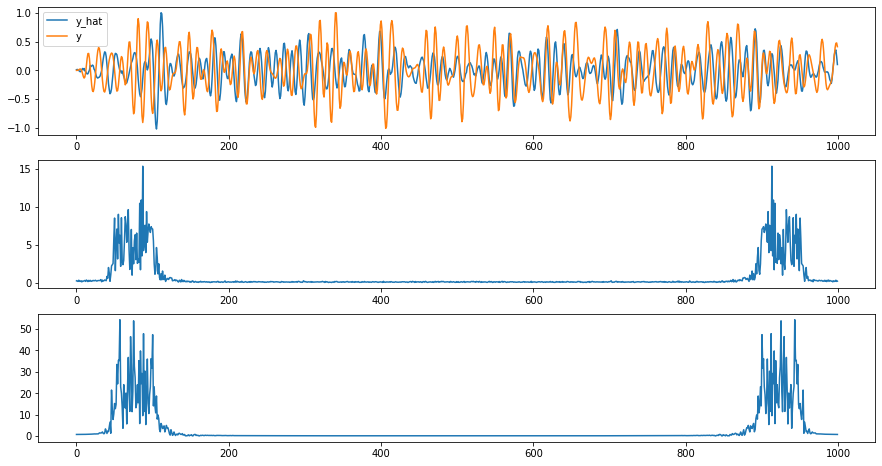

In [57]:
Model_results.append(evaluate(model,'ffnn_7.png'))

# RNN 

<img src='./meme/rnn_hot.jpg'>

# RNN model 1

In [28]:
class rnn(nn.Module):
    
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(rnn, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.RNN(input_size = input_dim, hidden_size = hidden_dim, nonlinearity='relu')
        self.fc = nn.Linear(in_features=hidden_dim*1000, out_features=1000)
        
    def forward(self, x):
        
        h_0 = torch.zeros(1,1,self.hidden_dim)
        
        out, h_n = self.rnn(x, h_0)
        out = self.fc(out.view(-1))
        
        return out

In [31]:
model = rnn(1,1,1)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.1)
criteria = nn.MSELoss()

Running Loss:  0.09946: 100%|██████████| 100/100 [51:25<00:00, 30.86s/it]


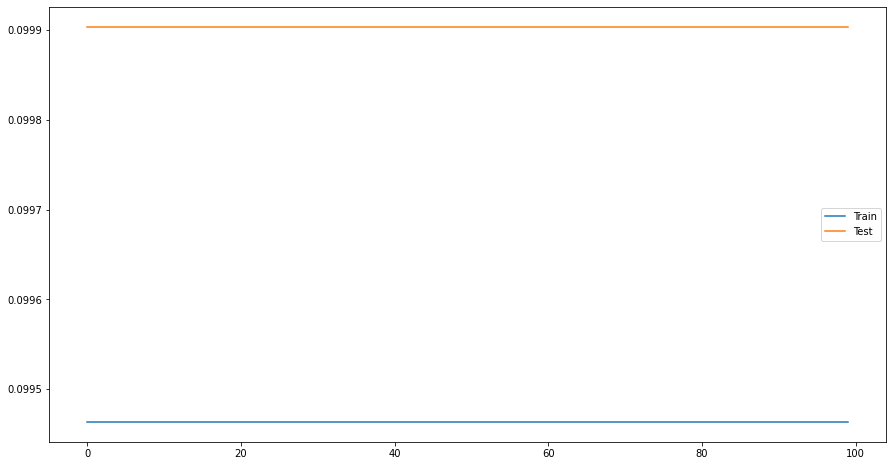

In [32]:
model.train()
epoch_nums = 100

running_loss_train = []
running_loss_test = []

epoch_t = tqdm.trange(epoch_nums,desc = 'Running Loss',leave = True)

for epoch in epoch_t:
    
    running_loss = 0
    i=0
    
    model.train()
    for x,y in train_loader:
        x = x.view(-1,1,1)
        y = y.view(-1)
        
        optim.zero_grad()

        y_hat = model.forward(x)

        loss = criteria(y_hat,y)
        loss.backward()
        
        optim.step()
        
        
        running_loss += (loss.item()-running_loss)/(i+1)
        i+=1
    
    epoch_t.set_description(f'Running Loss: {running_loss: .5f}')
    epoch_t.refresh()
    running_loss_train.append(running_loss)
    
    running_loss = 0
    i=0
    model.eval()
    for x,y in test_loader:
        x = x.view(-1,1,1)
        y = y.view(-1)
        
        y_hat = model.forward(x)
        
        loss = criteria(y_hat, y)
        
        running_loss += (loss.item()-running_loss)/(i+1)
        i+=1
    
    running_loss_test.append(running_loss)
    
plt.figure(figsize=(15,8))
plt.plot(running_loss_train, label='Train')
plt.plot(running_loss_test, label='Test')
plt.savefig('./loss/rnn_1.png')
plt.legend()
plt.show()

<img src='./meme/slow_nn.jpg'>

In [46]:
#torch.save(model.state_dict(),'./models/rnn_1.pth')

In [156]:
#model.load_state_dict(torch.load('./models/rnn_1.pth'))

Train Accuracy: -0.001 || Train Accuracy (FFT):  0.019
Test Accuracy: -0.004 || Test Accuracy (FFT):  0.019


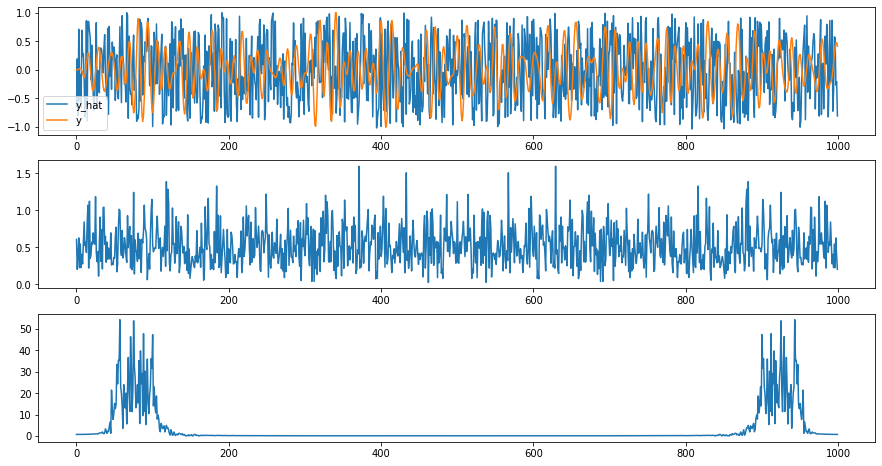

In [88]:
res = []

model.eval()

running_avg=0
running_avg_fft=0
i=0
for x,y in train_loader:
    x = x.view(-1,1,1)
    y = y.view(-1)
    
    y_hat = model.forward(x)
    Y_hat = abs(np.fft.fft(y_hat.detach().numpy()))
    Y = abs(np.fft.fft(y.numpy()))


    corr = np.corrcoef(y.numpy(),y_hat.detach().numpy())[0,1]
    corr_fft = np.corrcoef(Y,Y_hat)[0,1]

    running_avg += (corr - running_avg)/(i+1)
    running_avg_fft += (corr_fft - running_avg_fft)/(i+1)
    i+=1

print(f"Train Accuracy: {running_avg: .3f} || Train Accuracy (FFT): {running_avg_fft: .3f}")

res.append([running_avg,running_avg_fft])

running_avg=0
running_avg_fft=0
i=0
for x,y in test_loader:
    
    x = x.view(-1,1,1)
    y = y.view(-1)
    
    y_hat = model.forward(x)
    Y_hat = abs(np.fft.fft(y_hat.detach().numpy()))
    Y = abs(np.fft.fft(y.numpy()))


    corr = np.corrcoef(y.numpy(),y_hat.detach().numpy())[0,1]
    corr_fft = np.corrcoef(Y,Y_hat)[0,1]

    running_avg += (corr - running_avg)/(i+1)
    running_avg_fft += (corr_fft - running_avg_fft)/(i+1)
    i+=1


print(f"Test Accuracy: {running_avg: .3f} || Test Accuracy (FFT): {running_avg_fft: .3f}")

res.append([running_avg,running_avg_fft])

y_hat_test = model.forward(x_test[0].view(-1,1,1))

plt.figure(figsize=(15,8))

plt.subplot(311)
plt.plot(y_hat_test.detach().numpy() / y_hat_test.detach().numpy().max() , label='y_hat')
plt.plot(y_test[0] / y_test[0].max(), label='y')
plt.legend()

plt.subplot(312)
plt.plot(abs(np.fft.fft(y_hat_test.detach().numpy())))

plt.subplot(313)
plt.plot(abs(np.fft.fft(y_test[0])))

plt.savefig('./eval/rnn_1.png')
plt.show()

Model_results.append(res)

# Conclusion

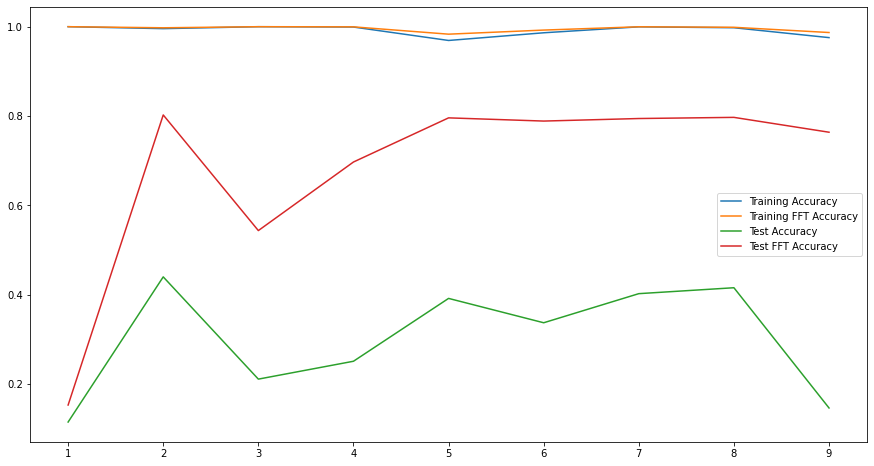

In [58]:
train_acc = [Model_results[i][0][0] for i in range(len(Model_results))]
train_fft_acc = [Model_results[i][0][1] for i in range(len(Model_results))]
test_acc = [Model_results[i][1][0] for i in range(len(Model_results))]
test_fft_acc = [Model_results[i][1][1] for i in range(len(Model_results))]



plt.figure(figsize=(15,8))

plt.plot(train_acc, label='Training Accuracy')
plt.plot(train_fft_acc, label='Training FFT Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.plot(test_fft_acc, label='Test FFT Accuracy')
plt.xticks(np.arange(0,len(Model_results)),np.arange(1,len(Model_results)+1))

plt.legend(loc='right')
plt.show()

# References

Paper: James Ting-Ho Lo (2009) Neural Filtering. Scholarpedia, 4(8):7868. [http://www.scholarpedia.org/article/Neural_Filtering]

**RNN:**
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
* https://karpathy.github.io/2015/05/21/rnn-effectiveness/
* https://peterroelants.github.io/posts/rnn-implementation-part01/
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/

Utilities:
* http://alexlenail.me/NN-SVG/index.html 


# Annex 1

<h2>Neural Networks for Noobs (Trying to give a intuitive idea)</h2>
<br>

<h3>Basically...</h3>
<img src='./meme/meme1.jpg'>
<br>
<span style='font-size: 18px'>
    A Neural Network is just a bunch of numbers that iteratively come close to predicting what the output would look like through steps of gradient descent.
</span>
<br>
<img src='./meme/be_like.jpg' style='width: 32em; height: 40em'>
<br>


<h3>Some math...</h3> 
<br>
<img src='./annex/wiki.png' style='width:50em; height:20em'>
<br>
<img src='./annex/nn_formulae_2.png'>
<br>
<img src='./annex/gd.png'>

<span style='font-size: 18px'>
    So, it's pretty simple right?
</span>


<h3>Some terminologies...</h3>
<br>
<span style='font-size: 18px'>
    <p>
    <strong>FFNN :</strong> Called a Feed Forward Neural Network. Essentially a simple network of fully connected neurons stacked on top of each other to form a layer, with  multiple layers to make the final network. <br>
    <strong>Parameters:</strong> The weights and biases used in the neural network. <br>
    <strong>Hyperparameters:</strong> Values that change how the neural network learns, like the learning rate, the architechture of the neural net etc. <br>
    <strong>Activation Function:</strong> Essentially a non-linearity added for the sake of getting approximations that can be non-linear in nature. Can be of multiple types; I primarily used ReLU though.<br>
    <p>
    <img src='./annex/activation.png'><br>
    <p><strong>Optimizing Algorithm:</strong> The algorithm that takes a tiny step in the direction of the gradient to iteratively arrive at the minimum. There are many types. I've used SGD with Momentum primarily.<br></p>
    <img src='./annex/optim.png'>  
    <p><strong>Loss criteria:</strong>The function of the prediction and the acutal output that converts the difference between them into a convex function, for which we can find the point of minimum loss.</p>
</span>


<h3>Black Box Intuition</h3>
<span style='font-size: 18px'>
    Most neural networks work like black boxes of millions of numbers that give out the output. It's very hard to explain what a neuron in a Artificial Neural Network learns; infact it's an entire field in AI called Explainable AI.
</span>
<img src='./meme/funny_xkcd.png'>

# Annex 2

<h2>Regularization</h2>

<h3>Why?</h3>
<img src='./annex/reg_need.png' style='width:25em ; height:25em'>
<br>
<h3>L2 regularization</h3>
<img src='./annex/L2_reg.png'>
<br>
<h3>Dropout</h3>
<img src='./annex/dropout.png'>
<br>
<span style='font-size:18px'>
    <p>
        <strong>Basically...</strong>
    </p>
</span>
<br>
<img src='./meme/dropout_meme.jpeg' style='width:20em; height:30em'>